## Imports

In [1]:
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
filepath = 'data/logins.json'

with open(filepath, "r") as f:
    logins = json.load(f)

In [3]:
#view data structure. Only 1 entry point in json: login_time
logins['login_time'][:5]

['1970-01-01 20:13:18',
 '1970-01-01 20:16:10',
 '1970-01-01 20:16:37',
 '1970-01-01 20:16:36',
 '1970-01-01 20:26:21']

In [4]:
# save down to just the raw data, not having the nested json
login_data = logins['login_time']
login_data[:5]

['1970-01-01 20:13:18',
 '1970-01-01 20:16:10',
 '1970-01-01 20:16:37',
 '1970-01-01 20:16:36',
 '1970-01-01 20:26:21']

In [5]:
#Load to a pandas df
login_df = pd.DataFrame(login_data, columns=['login_time'])
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
#check dtypes to make sure it really is a timestamp
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [7]:
#convert using the to_datetime function
login_df['login_time'] = pd.to_datetime(login_df['login_time'])

In [8]:
#validate
print(login_df.head())
print('--'*50)
print(login_df.info())

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


## Initial Exploration

In [9]:
login_df.shape

(93142, 1)

In [10]:
#look for abnormal amount of logins
login_df['login_time'].value_counts()

1970-03-17 01:01:39    3
1970-01-06 21:45:52    3
1970-03-29 03:24:57    3
1970-04-12 04:03:15    3
1970-04-04 01:17:40    3
                      ..
1970-02-13 21:05:25    1
1970-02-13 21:10:52    1
1970-02-13 21:20:04    1
1970-02-13 21:12:19    1
1970-04-13 18:54:23    1
Name: login_time, Length: 92265, dtype: int64

I'm surprised to see any duplicates down to the second, but it is not out of the realm of possibility and the max is only 3.

In [11]:
#when is the first login
login_df['login_time'].min()

Timestamp('1970-01-01 20:12:16')

In [12]:
#when is the most recent login?
login_df['login_time'].max()

Timestamp('1970-04-13 18:57:38')

In [13]:
#any blanks?
login_df.isnull().sum()

login_time    0
dtype: int64

## Aggregate Data

Convert this data into a count of logins in 15-minute intervals.

In [14]:
login_df.head(10)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


### Prep and Perform Resampling to Aggregate

In [15]:
#set the login_time as the index
login_df.set_index('login_time', inplace=True)

#add a count column
login_df['logins'] = 1

#resample
login_15 = login_df.resample('15T').sum()

In [16]:
login_15.head()

,logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


## Further Exploration

### EDA Cleaning Review

Explore data and look for any issues.

In [17]:
#view shape
login_15.shape

(9788, 1)

In [18]:
#any NAs after resampiing?
login_15.isnull().sum()

logins    0
dtype: int64

In [19]:
#any duplicate login_time bins?
login_15[login_15.index.duplicated()]

,logins
login_time,


In [20]:
#summary statistics
login_15.describe()

,logins
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


### Distribution and Boxplot

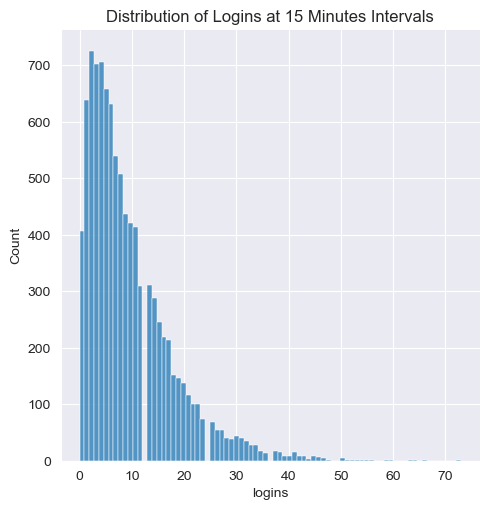

In [21]:
sns.set_style("darkgrid")

sns.displot(login_15, x='logins')

plt.title('Distribution of Logins at 15 Minutes Intervals')
plt.show()

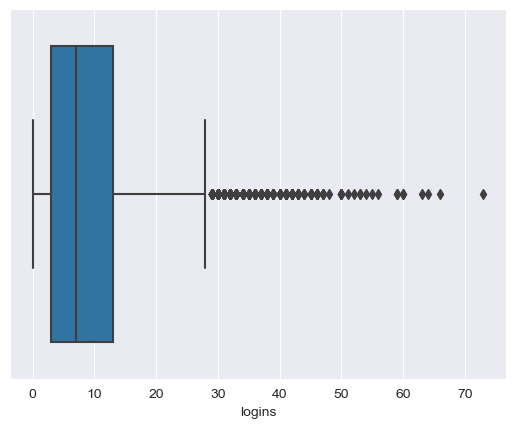

In [22]:
sns.boxplot(x=login_15['logins'])
plt.show()

**Observations**
The distribution is highly skewed, and we can see those outliers show up in the box plot. Without knowing more about the source of the data, I will chock that up to specific demand peaks which I'll now explore more.

## Visualizaiton

Explore the data more to try to better understand and explain.

### Long-term Trend

In [23]:
#promote index for simpler x,y calls
login_15.reset_index(inplace=True)

In [24]:
login_15.head()

,login_time,logins
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [26]:
login_15.columns

Index(['login_time', 'logins'], dtype='object')

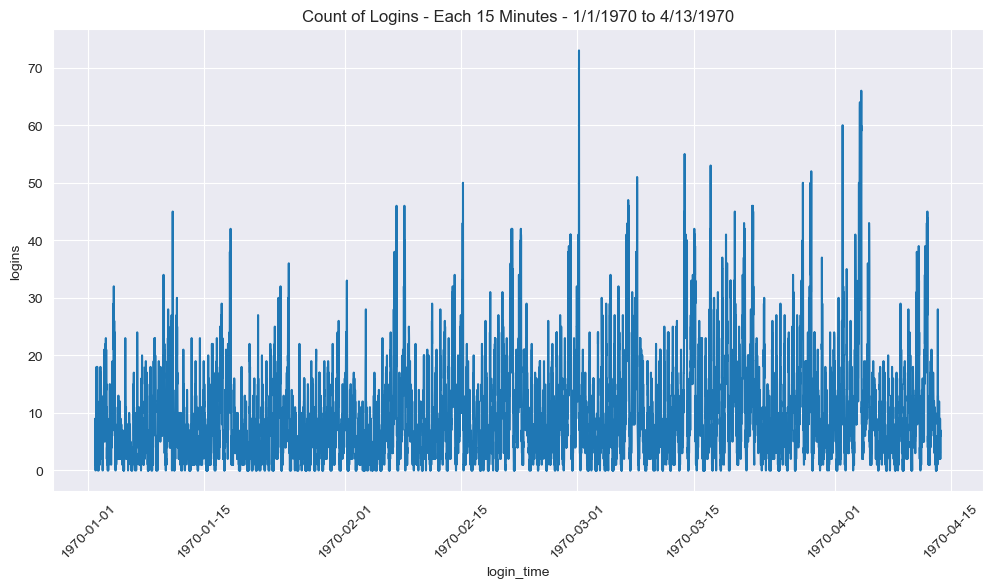

In [36]:
plt.figure(figsize=(12,6))

sns.lineplot(x='login_time', y='logins', data=login_15)

plt.title('Count of Logins - Each 15 Minutes - 1/1/1970 to 4/13/1970')
plt.xticks(rotation=45)

plt.show()